## 🔍 Exploratory Data Analysis (EDA)

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
train_data = pd.read_csv('train.csv')
target_data = pd.read_csv('target.csv')
test_data = pd.read_csv('test.csv')
submission_format = pd.read_csv('submission_format.csv')

# Basic information about the datasets
print(f"Train shape: {train_data.shape}")
print(f"Target shape: {target_data.shape}")
print(f"Test shape: {test_data.shape}")
print(f"Submission format shape: {submission_format.shape}")

# Check column names
print("\nTrain columns:", train_data.columns.tolist())
print("\nTarget column:", target_data.columns.tolist())
print("\nTest columns:", test_data.columns.tolist())

# Check target distribution
target_counts = target_data['coppaRisk'].value_counts(normalize=True)
print("\nTarget distribution:")
print(target_counts)
print(f"Class imbalance ratio: {target_counts.min():.4f}")

# Check missing values
train_missing = train_data.isnull().sum().sort_values(ascending=False)
train_missing_pct = (train_missing / len(train_data) * 100).round(2)
train_missing_df = pd.DataFrame({'Count': train_missing, 'Percentage': train_missing_pct})
print("\nMissing values in training data:")
print(train_missing_df[train_missing_df['Count'] > 0])

Train shape: (7000, 16)
Target shape: (7000, 1)
Test shape: (3000, 17)
Submission format shape: (3000, 2)

Train columns: ['developerCountry', 'countryCode', 'userRatingCount', 'primaryGenreName', 'downloads', 'deviceType', 'hasPrivacyLink', 'hasTermsOfServiceLink', 'hasTermsOfServiceLinkRating', 'isCorporateEmailScore', 'adSpent', 'appAge', 'averageUserRating', 'appContentBrandSafetyRating', 'appDescriptionBrandSafetyRating', 'mfaRating']

Target column: ['coppaRisk']

Test columns: ['ID', 'developerCountry', 'countryCode', 'userRatingCount', 'primaryGenreName', 'downloads', 'deviceType', 'hasPrivacyLink', 'hasTermsOfServiceLink', 'hasTermsOfServiceLinkRating', 'isCorporateEmailScore', 'adSpent', 'appAge', 'averageUserRating', 'appContentBrandSafetyRating', 'appDescriptionBrandSafetyRating', 'mfaRating']

Target distribution:
coppaRisk
False    0.900571
True     0.099429
Name: proportion, dtype: float64
Class imbalance ratio: 0.0994

Missing values in training data:
                  

## ⚠️ Analisis Masalah Data: Class Imbalance & Missing Values

### 📊 Class Imbalance
Distribusi label pada dataset menunjukkan ketidakseimbangan kelas yang signifikan:

- **~90%** data termasuk dalam kelas **negatif** (*not at risk*)
- **~10%** data termasuk dalam kelas **positif** (*at risk*)

➡️ Ketidakseimbangan ini dapat memengaruhi performa model klasifikasi, terutama dalam mendeteksi kasus positif. Strategi penanganan seperti **resampling**, **penyesuaian threshold**, atau **penggunaan metrik seperti F1-Score** perlu dipertimbangkan.

---

### 🔍 Analisis Missing Values

Beberapa fitur memiliki proporsi nilai hilang yang cukup besar:

| Fitur                             | Persentase Missing | Catatan                                               |
|----------------------------------|---------------------|--------------------------------------------------------|
| `appContentBrandSafetyRating`    | 88%                 | Terlalu banyak missing, kemungkinan tidak berguna     |
| `adSpent`                        | 81%                 | Perlu penanganan khusus seperti imputasi atau flag    |
| `hasTermsOfServiceLink`          | 66%                 | Mungkin mengandung informasi dari missing-nya         |
| `hasTermsOfServiceLinkRating`    | 66%                 | Sama seperti di atas, potensi missingness yang bermakna |
| `downloads`                      | 31%                 | Masih bisa digunakan setelah imputasi atau analisis lanjut |
| (4 fitur lainnya)                | 10–18%              | Perlu dipertimbangkan untuk imputasi atau penghapusan |

➡️ Missing values harus dianalisis lebih lanjut apakah bersifat **MCAR**, **MAR**, atau **MNAR**, dan ditangani sesuai jenisnya.


In [11]:
# Check data types
print("\nData types:")
print(train_data.dtypes)

# Get unique values for categorical features
categorical_features = train_data.select_dtypes(include=['object']).columns.tolist()
print(f"\nCategorical features: {categorical_features}")

# Check unique values and counts for key categorical features
for feature in categorical_features:
    unique_count = train_data[feature].nunique()
    top_values = train_data[feature].value_counts().head(5)
    print(f"\n{feature} ({unique_count} unique values):")
    print(top_values)
    
    # Check for placeholder values
    placeholders = [val for val in train_data[feature].dropna().unique() 
                   if isinstance(val, str) and any(p in val.upper() for p in 
                                                  ['UNKNOWN', 'NOT', 'GLOBAL', 'UNAVAILABLE'])]
    if placeholders:
        print(f"Potential placeholders: {placeholders}")

# Check numeric feature distributions
numeric_features = train_data.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(f"\nNumeric features: {numeric_features}")

# Display summary statistics for numeric features
print("\nNumeric feature statistics:")
print(train_data[numeric_features].describe())

# Now let's see how the target relates to having privacy and terms links
print("\nCross-tabulation of hasPrivacyLink vs target:")
privacy_crosstab = pd.crosstab(train_data['hasPrivacyLink'], 
                               target_data['coppaRisk'],
                               normalize='index')
print(privacy_crosstab)

print("\nCross-tabulation of hasTermsOfServiceLink vs target:")
tos_crosstab = pd.crosstab(train_data['hasTermsOfServiceLink'], 
                           target_data['coppaRisk'],
                           normalize='index')
print(tos_crosstab)


Data types:
developerCountry                    object
countryCode                         object
userRatingCount                      int64
primaryGenreName                    object
downloads                           object
deviceType                          object
hasPrivacyLink                      object
hasTermsOfServiceLink               object
hasTermsOfServiceLinkRating         object
isCorporateEmailScore              float64
adSpent                            float64
appAge                             float64
averageUserRating                  float64
appContentBrandSafetyRating         object
appDescriptionBrandSafetyRating     object
mfaRating                           object
dtype: object

Categorical features: ['developerCountry', 'countryCode', 'primaryGenreName', 'downloads', 'deviceType', 'hasPrivacyLink', 'hasTermsOfServiceLink', 'hasTermsOfServiceLinkRating', 'appContentBrandSafetyRating', 'appDescriptionBrandSafetyRating', 'mfaRating']

developerCountry (114 uni

In [19]:
# Buat target numerik yang benar
target_numeric = target_data['coppaRisk'].astype(int)
print("Distribusi target numerik:")
print(target_numeric.value_counts())

# Contoh untuk memverifikasi konversi benar
print("\nBeberapa baris pertama:")
print(pd.DataFrame({
    'original': target_data['coppaRisk'],
    'numeric': target_numeric
}).head(10))

# Sekarang kita ulangi analisis dengan target yang benar
# Analyze categorical features vs target
for feature in ['primaryGenreName', 'downloads', 'mfaRating', 'appDescriptionBrandSafetyRating']:
    # Skip if too many missing values
    if train_data[feature].isnull().mean() > 0.5:
        print(f"\nSkipping {feature} - too many nulls")
        continue
        
    # Calculate risk rate for each category
    feature_risk = {}
    for category in train_data[feature].dropna().unique():
        # Get rows with this category
        mask = train_data[feature] == category
        # Calculate risk rate
        risk_rate = target_numeric[mask].mean()
        # Store with sample count
        count = mask.sum()
        if count >= 10:  # Only include categories with enough samples
            feature_risk[category] = {'risk_rate': risk_rate, 'count': count}
    
    # Convert to DataFrame and sort
    risk_df = pd.DataFrame.from_dict(feature_risk, orient='index')
    risk_df = risk_df.sort_values('risk_rate', ascending=False)
    
    # Show top and bottom categories
    print(f"\n{feature} vs COPPA Risk (top 5 highest risk categories):")
    print(risk_df.head(5))
    
    print(f"\n{feature} vs COPPA Risk (bottom 5 lowest risk categories):")
    print(risk_df.tail(5))

# Check missing values vs target
print("\nCorrelation of missing values with COPPA Risk:")
for feature in train_data.columns:
    missing_pct = train_data[feature].isnull().mean()
    if missing_pct > 0.1:
        # Calculate risk rate when feature is missing
        is_missing = train_data[feature].isnull()
        risk_when_missing = target_numeric[is_missing].mean()
        risk_when_present = target_numeric[~is_missing].mean()
        
        print(f"{feature}: Missing={risk_when_missing:.4f}, Present={risk_when_present:.4f}, " + 
              f"Diff={risk_when_missing-risk_when_present:.4f}")

Distribusi target numerik:
coppaRisk
0    6304
1     696
Name: count, dtype: int64

Beberapa baris pertama:
   original  numeric
0     False        0
1     False        0
2     False        0
3     False        0
4     False        0
5     False        0
6      True        1
7     False        0
8     False        0
9     False        0

primaryGenreName vs COPPA Risk (top 5 highest risk categories):
               risk_rate  count
Education       0.376000    500
Stickers        0.250000     20
Games           0.234683   1828
Reference       0.142857     21
Entertainment   0.113689    431

primaryGenreName vs COPPA Risk (bottom 5 lowest risk categories):
                  risk_rate  count
News & Magazines        0.0     74
Events                  0.0     23
Health & Fitness        0.0    211
Beauty                  0.0     21
Travel & Local          0.0     99

downloads vs COPPA Risk (top 5 highest risk categories):
                       risk_rate  count
100000000 - 500000000   0.441

Visualisasi telah dibuat dan disimpan.

Membuat fitur-fitur baru...
Fitur-fitur baru telah dibuat dan data disimpan.


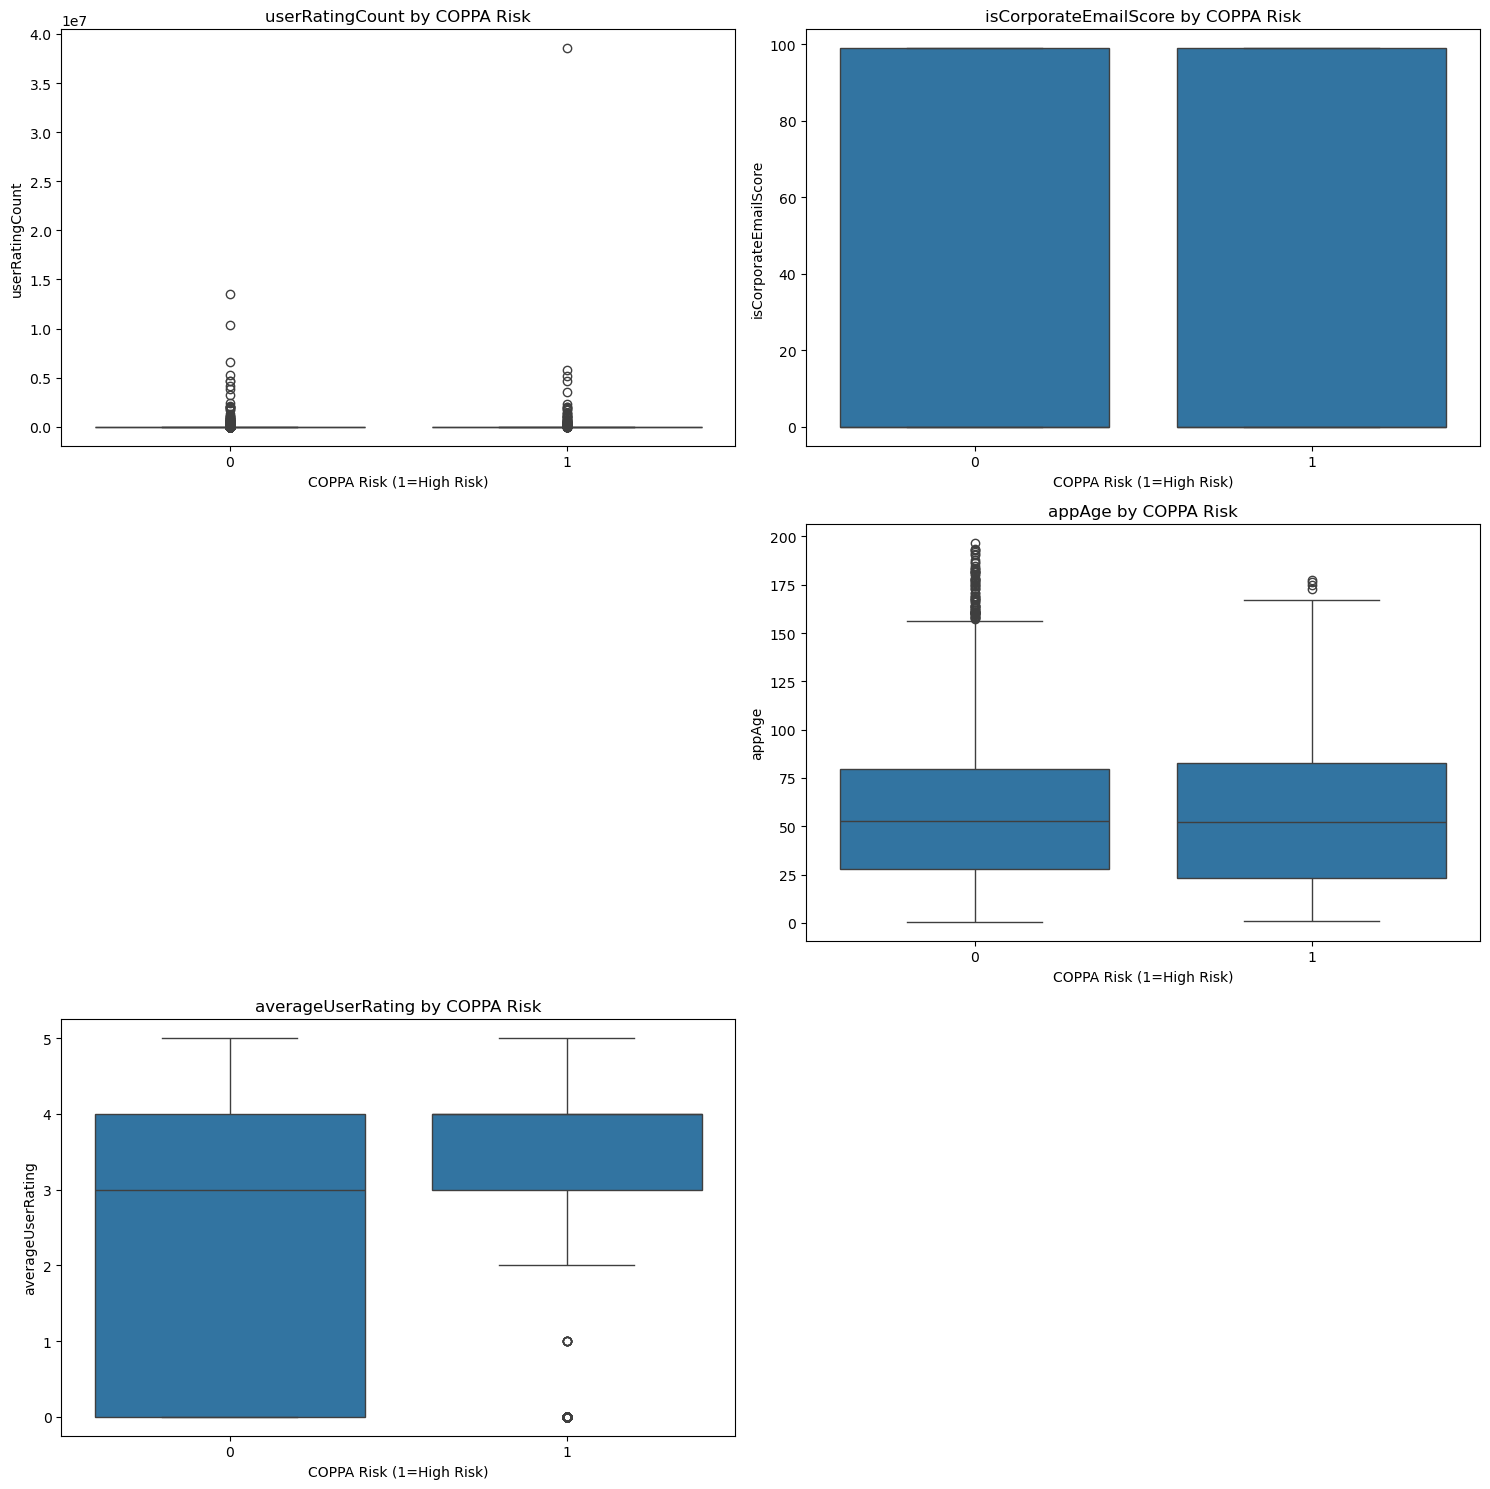

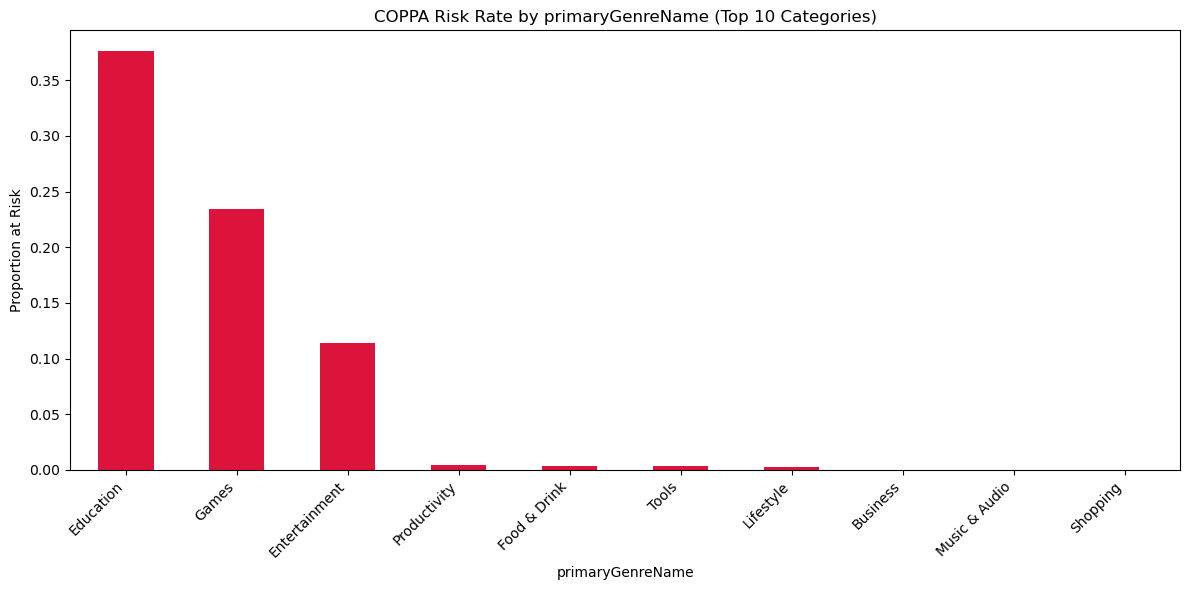

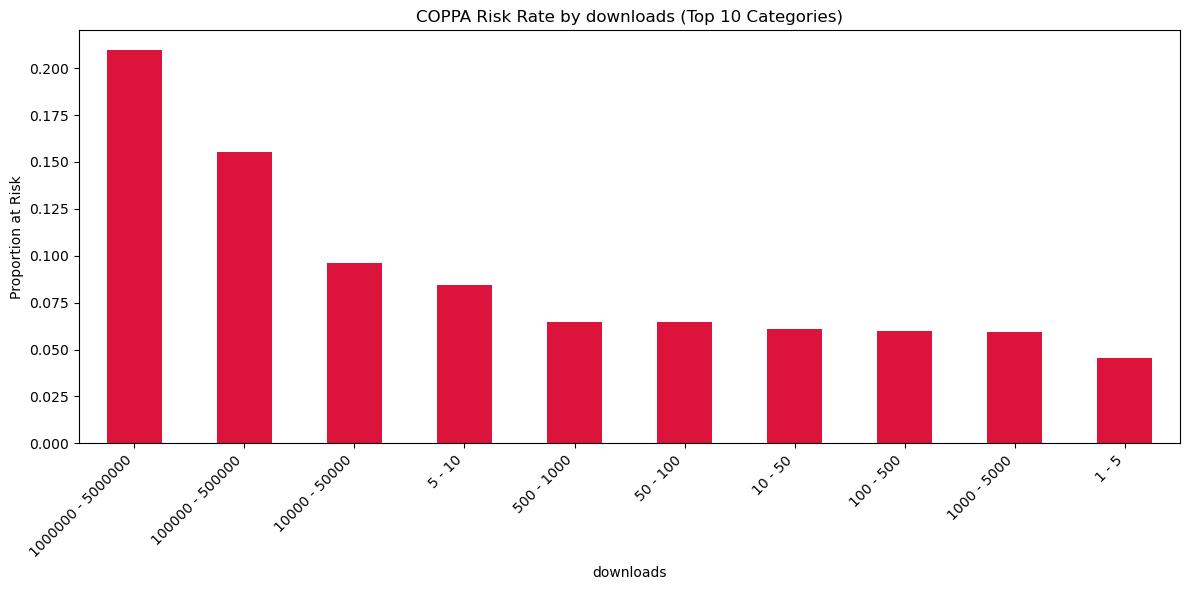

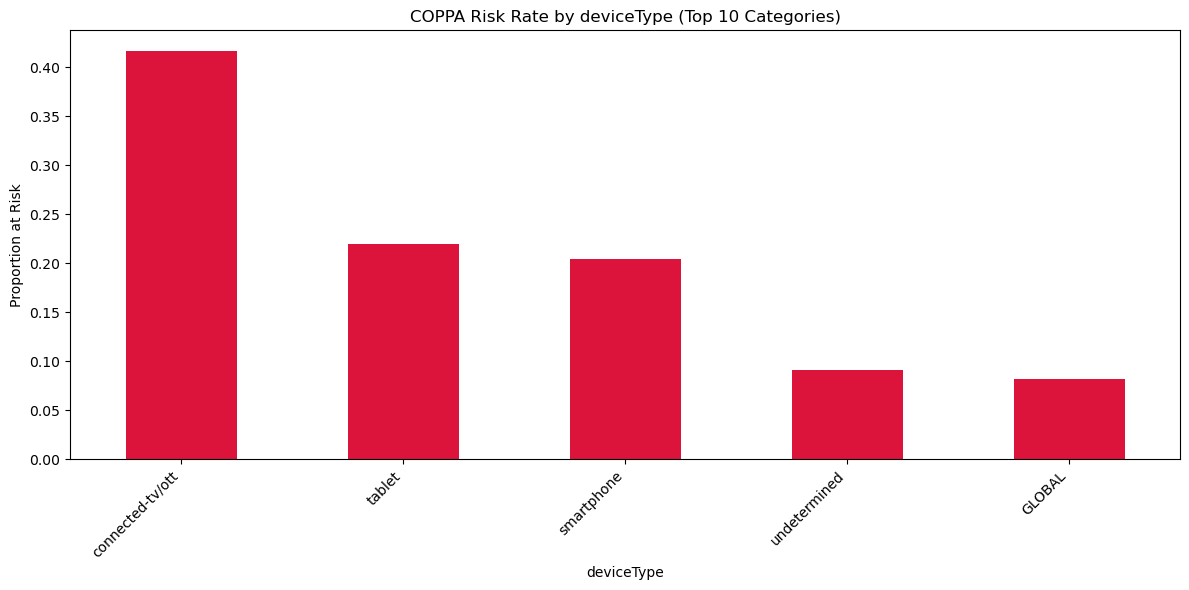

In [21]:
# Kita perlu melihat hubungan antara fitur numerik dan target
import matplotlib.pyplot as plt
import seaborn as sns

# Konversi target ke numerik
y = target_data['coppaRisk'].astype(int)

# Analisis fitur numerik
numeric_features = ['userRatingCount', 'isCorporateEmailScore', 'adSpent', 'appAge', 'averageUserRating']

# Buat figure dengan ukuran yang cukup besar
plt.figure(figsize=(15, 15))

# Plot boxplot untuk setiap fitur numerik
for i, feature in enumerate(numeric_features):
    # Lewati jika terlalu banyak nilai hilang
    if train_data[feature].isnull().mean() > 0.5:
        continue
        
    plt.subplot(3, 2, i+1)
    # Isi nilai yang hilang dengan median untuk visualisasi
    data_for_plot = train_data[feature].fillna(train_data[feature].median())
    
    # Buat boxplot berdasarkan target
    sns.boxplot(x=y, y=data_for_plot)
    plt.title(f'{feature} by COPPA Risk')
    plt.xlabel('COPPA Risk (1=High Risk)')
    plt.ylabel(feature)

plt.tight_layout()
plt.savefig('numeric_features_by_target.png')  # Simpan gambar untuk analisis

# Lihat juga distribusi kategori untuk fitur kategoris teratas
categorical_features = ['primaryGenreName', 'downloads', 'deviceType']

for feature in categorical_features:
    # Hitung proporsi kelas positif untuk setiap kategori
    cross_tab = pd.crosstab(train_data[feature], y, normalize='index')
    
    # Ambil top 10 kategori berdasarkan frekuensi
    top_categories = train_data[feature].value_counts().head(10).index
    
    # Filter data
    plot_data = cross_tab.loc[top_categories].sort_values(by=1, ascending=False)
    
    # Plot
    plt.figure(figsize=(12, 6))
    plot_data[1].plot(kind='bar', color='crimson')
    plt.title(f'COPPA Risk Rate by {feature} (Top 10 Categories)')
    plt.ylabel('Proportion at Risk')
    plt.xlabel(feature)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f'{feature}_risk_rate.png')  # Simpan gambar

print("Visualisasi telah dibuat dan disimpan.")

# Buat fitur baru berdasarkan wawasan yang telah kita temukan
print("\nMembuat fitur-fitur baru...")

# Buat copy dari data train dan test
train_fe = train_data.copy()
test_fe = test_data.copy()

# 1. Flag untuk aplikasi pendidikan dan game (kategori berisiko tinggi)
train_fe['is_high_risk_category'] = train_fe['primaryGenreName'].isin(['Education', 'Games', 'Stickers']).astype(int)
test_fe['is_high_risk_category'] = test_fe['primaryGenreName'].isin(['Education', 'Games', 'Stickers']).astype(int)

# 2. Flag untuk aplikasi dengan unduhan tinggi
def unduhan_tinggi(download_str):
    if pd.isna(download_str):
        return 0
    try:
        # Ekstrak nilai pertama dari range
        first_num = download_str.split('-')[0].strip().replace(',', '')
        return 1 if float(first_num) >= 500000 else 0
    except:
        return 0

train_fe['is_high_downloads'] = train_fe['downloads'].apply(unduhan_tinggi)
test_fe['is_high_downloads'] = test_fe['downloads'].apply(unduhan_tinggi)

# 3. Flag untuk nilai yang hilang pada fitur penting
for feature in ['hasPrivacyLink', 'hasTermsOfServiceLink', 'appContentBrandSafetyRating', 'adSpent']:
    train_fe[f'{feature}_missing'] = train_fe[feature].isnull().astype(int)
    test_fe[f'{feature}_missing'] = test_fe[feature].isnull().astype(int)

# 4. Total nilai yang hilang per aplikasi
train_fe['total_missing'] = train_fe.isnull().sum(axis=1)
test_fe['total_missing'] = test_fe.isnull().sum(axis=1)

# Simpan data yang sudah diengineering
train_fe.to_csv('train_fe.csv', index=False)
test_fe.to_csv('test_fe.csv', index=False)

print("Fitur-fitur baru telah dibuat dan data disimpan.")